## Problem Statement

This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.

## Dataset Attributes
This file contains the dataset of job descriptions and their meta information. A small proportion of these descriptions are fake or scam which can be identified by the column "fraudulent".
1. job_id - Unique Job ID
2. title - The title of the job ad entry
3. location - Geographical location of the job ad
4. department - Corporate department (e.g. sales)
5. salary_range - Indicative salary range in USD (e.g. 50,000-60,000)
6. company_profile - A brief company description
7. description - The details description of the job ad
8. requirements - Enlisted requirements for the job opening
9. benefits - Enlisted offered benefits by the employe
10. telecommuting - True for telecommuting positions
11. has_company_logo - True if company logo is present
12. has_questions - True if screening questions are presen
13. employment_type - Full-type, Part-time, Contract, etc.
14. required_experience - Executive, Entry level, Intern, etc.
15. required_education - Doctorate, Master’s Degree, Bachelor, etc.
16. industry - Automotive, IT, Health care, Real estate, etc.
17. function - Consulting, Engineering, Research, Sales etc.
18. fraudulent - target - Classification attribute (1=Fraudulent)

**Libraries Used**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('fake_job_postings.csv')

## Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
df.shape

(17880, 18)

In [5]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
# All fraudulent job listings
df[df['fraudulent']==1]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
144,145,Forward Cap.,NaN,NaN,NaN,NaN,The group has raised a fund for the purchase o...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1
173,174,Technician Instrument & Controls,US,Power Plant & Energy,NaN,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1
180,181,Sales Executive,"PK, SD, Karachi",Sales,NaN,NaN,Sales Executive,Sales Executive,Sales Executive,0,0,0,NaN,NaN,NaN,NaN,Sales,1
215,216,IC&E Technician Mt Poso,"US, CA, Bakersfield, CA / Mt. Poso",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17827,17828,Student Positions Part-Time and Full-Time.,"US, CA, Los Angeles",NaN,NaN,NaN,Student Positions Part-Time and Full-Time.You ...,NaN,NaN,0,0,0,Part-time,NaN,NaN,NaN,NaN,1
17828,17829,Sales Associate,"AU, NSW, Sydney",Sales and Marketing,NaN,NaN,LEARN TO EARN AN EXECUTIVE LEVEL INCOMEFULL TR...,What You Can Do. • Have the potential to earn ...,Who We Are We are a Global Leadership Developm...,0,0,1,NaN,NaN,NaN,NaN,NaN,1
17829,17830,Android Developer,"PL, MZ, Warsaw",NaN,NaN,NaN,inFullMobile Sp. z o.o. is a mobile software d...,• A proven track record in Android / JAVA proj...,attractive salary (adequate to the candidate s...,0,0,0,NaN,NaN,NaN,NaN,NaN,1
17830,17831,Payroll Clerk,"US, NY, New York",NaN,NaN,NaN,JOB DESCRIPTIONWe are seeking a full time payr...,JOB REQUIREMENTS• High school diploma or eq...,We offer a competitive salary and benefits pac...,0,0,0,Full-time,NaN,NaN,Apparel & Fashion,Accounting/Auditing,1


In [7]:
# Number of null values in dataset
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

To predict whether a listing is fraudulent or not, I need to choose the variables that have a combination of the least null values yet the most text. Therefore, I will choose only the 'description' column as my independent variable.

In [8]:
df = df[['description','fraudulent']]
df.head()

,description,fraudulent
0,"Food52, a fast-growing, James Beard Award-winn...",0
1,Organised - Focused - Vibrant - Awesome!Do you...,0
2,"Our client, located in Houston, is actively se...",0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0


In [9]:
df = df.dropna()

## Text Cleaning

In [10]:
# All English stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Cleaning our text is very important for creating an accurate model. To clean our text, we will:

* Remove stopwords, which are basically words in a language that do not give much information on their own (Check the list above for examples)

* Remove punctuation, which does not give information on its own

* Convert text to lowercase to reduce word variability (Cat $\neq$ cat)

* Lemmatize words to reduce word variability. I have provided a diagram of the lemmatization process below:

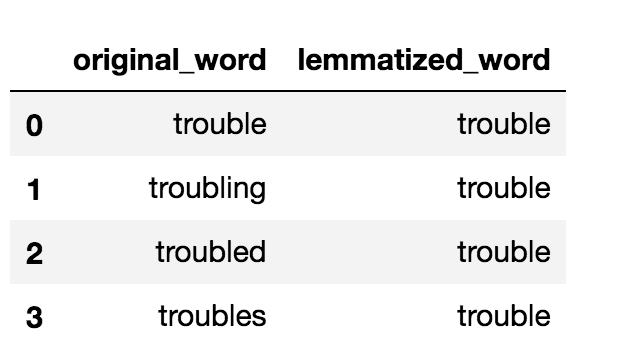

In [11]:
lemmatizer = WordNetLemmatizer()
punctuation = list(string.punctuation)
stop = set(stopwords.words('english') + punctuation)
stop.update(punctuation)

def text_cleaner(messy):
    clean_text = []
    for word in messy.split():
        if word.lower() not in stop:
            lem = lemmatizer.lemmatize(word)
            clean_text.append(lem.lower())
    return " ".join(clean_text)

In [12]:
# Applying text-cleaning function to 'description' column
df['description'] = df['description'].apply(text_cleaner)

## Data Vectorization with TF-IDF

All machine learning models are some kind of mathematical model that need numbers to work with, so we will convert our text to numerical values. We will be using Term Frequency Inverse Document Frequency (TFIDF) Vectorizer to convert and sum all words per review to a numerical value. Then, we will use TF-IDF to assign a weight to each word per review. 

An example of this process has been given below.

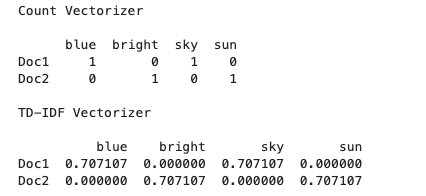

In [13]:
# Max number of unique words = 5,000
text_bag = TfidfVectorizer(max_features=5000,ngram_range=(2,2)).fit_transform(df['description'])

In [14]:
text_bag_transform = TfidfTransformer().fit_transform(text_bag)
X = text_bag_transform.toarray()

In [15]:
LE = LabelEncoder()
y = LE.fit_transform(df['fraudulent'])
y = np.asarray(y).astype('float32').reshape((-1,1))

In [16]:
print(X.shape)
print(y.shape)

(17879, 5000)
(17879, 1)


## Handling Target Imbalance with SMOTE

Text(0.5, 1.0, 'Fraudulent Vs. Nonfraudulent Count')

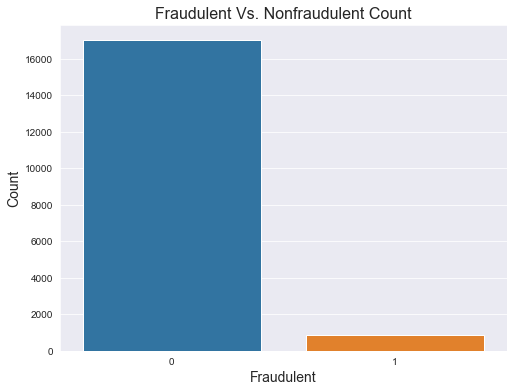

In [17]:
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.countplot(x='fraudulent',data=df)
plt.xlabel('Fraudulent',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title('Fraudulent Vs. Nonfraudulent Count', fontsize=16)

In [18]:
df['fraudulent'].value_counts()

0    17014
1      865
Name: fraudulent, dtype: int64

There are 17,014 fraudulent listings, but only 865 fraudulent listings. In a classification models, severely imbalanced classes like this usually leads to poor model performance. Therefore, I will be creating synthetic data that is relatively close and plausible to the minority (fraudulent) class such that there are 17,014 nonfraudulent as well as 17,014 fraudulents listings in the dataset. This allows for the model to learn more and become more accurate when predicting the neutral and negative ratings.

In [19]:
oversampling_smote = SMOTE(sampling_strategy={1:17014})
undersampling = RandomUnderSampler(sampling_strategy={0:17014})
pipeline = Pipeline([('under', undersampling), ('smote', oversampling_smote)])
df_train_resampled = pipeline.fit_resample(X, y)
X_smote = df_train_resampled[0] # Resampled X
y_smote = df_train_resampled[1] # Resample y

In [20]:
print(X_smote.shape)
print(y_smote.shape)

(34028, 5000)
(34028,)


## Train Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=101)

## Creating Deep Neural Network

In [22]:
model = Sequential()
model.add(Dense(64,input_shape=(X_smote.shape),activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [23]:
# Creating an Early Stop parameter to avoid model overfitting
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=3,patience = 5)

In [24]:
model.fit(x=X_train,
          y=y_train,
          batch_size=128,
          epochs=25,
          callbacks=[early_stop],
          validation_data=(X_test,y_test),
          validation_steps=1)

Epoch 1/25
187/187 [==============================] - 1s 3ms/step - loss: 0.4974 - accuracy: 0.7324 - val_loss: 0.0827 - val_accuracy: 0.9922
Epoch 2/25
187/187 [==============================] - 0s 3ms/step - loss: 0.2217 - accuracy: 0.9287 - val_loss: 0.0263 - val_accuracy: 0.9922
Epoch 3/25
187/187 [==============================] - 0s 3ms/step - loss: 0.1594 - accuracy: 0.9638 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 4/25
187/187 [==============================] - 0s 3ms/step - loss: 0.1392 - accuracy: 0.9702 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 5/25
187/187 [==============================] - 0s 2ms/step - loss: 0.1245 - accuracy: 0.9700 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 6/25
187/187 [==============================] - 0s 3ms/step - loss: 0.1118 - accuracy: 0.9731 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 7/25
187/187 [==============================] - 0s 2ms/step - loss: 0.1079 - accuracy: 0.9707 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 

In [25]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

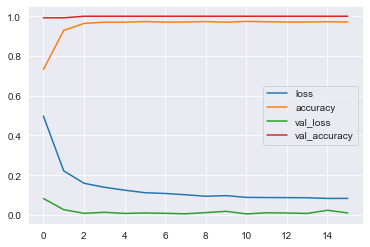

In [26]:
model_loss.plot()

This shows that early stopping was triggered so that validation loss was minimized. Our model has been trained beautifully. Our training loss and validation loss quickly went down while training accuracy quickly increased.

In [27]:
# Making predictions with the test data subset and checking model accuracy
from sklearn.metrics import classification_report, confusion_matrix

predictions = (model.predict(X_test) > 0.5).astype('int32')

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      5100
         1.0       0.97      1.00      0.98      5109

    accuracy                           0.98     10209
   macro avg       0.98      0.98      0.98     10209
weighted avg       0.98      0.98      0.98     10209



## Conclusion

With this model, we were able to achieve:

* 98% f1-score when identifying fraudulent job listings
* 98% overall accuracy

By cleaning our text, converting & vectorizing it to numerical values using TF-IDF, and finally rebalancing it using SMOTE, our neural network has proven to be very accurate at identifying fraudulent job listings. This model would be useful for website moderators to quickly remove phony job listings and to foster a clean, positive environment for people who are looking for a new job.

There are certainly more extensive approaches we can still take here, but this is a relatively simple neural network that works well!